In [1]:
from concurrent.futures import ThreadPoolExecutor
import os
import random
import numpy as np
import json
import tarfile
from tqdm import tqdm
import subprocess
import tensorflow_datasets as tfds
import cv2

from PIL import Image
from IPython import display

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import matplotlib.pyplot as plt

def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

def save_imgs(imgs, path):
  for i, img in enumerate(imgs):
    # save as 00000.jpg, 00001.jpg, ...
    img.save(f"{path}/{i:05d}.jpg")

In [2]:
data_root = f'/media/gvl/ACDA-BDB0/datasets/bridge/bridge_dataset/1.0.0'
b_tfds = tfds.builder_from_directory(builder_dir=data_root)

samples_all = {
    'train': {},
    'val': {}
}

for trainval in ['val', 'train']:
    ds = b_tfds.as_dataset(split=trainval)
    if not os.path.exists(f'demo/{trainval}'):
        os.makedirs(f'demo/{trainval}')
    for episode in tqdm(ds):
        images = [step['observation']['image_0'] for step in episode['steps']]
        new_width = 128
        new_height = 128
        resized_images = []

        for image in images:
            resized_image = Image.fromarray(image.numpy()).resize((new_width, new_height))
            resized_images.append(resized_image)
        save_imgs(resized_images, f'demo/{trainval}/')

        ee_traj_6d = [step['observation']['state'] for step in episode['steps']]
        ee_traj_6d = np.array(ee_traj_6d)
        np.save(f'ee_traj_6d.npy', ee_traj_6d)

        break
    break

2025-02-17 00:11:00.753791: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 00:11:00.761069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739779860.770122  788559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739779860.772603  788559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 00:11:00.781820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Try SAM2 here

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
from sam2.build_sam import build_sam2_video_predictor
print(os.getcwd())
sam2_checkpoint = "third_party/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/home/gvl/Documents/Junjie/projects/ours/oxe_cam_calibration


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

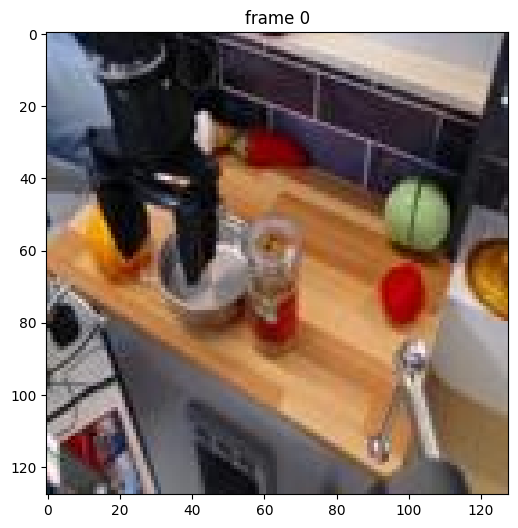

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "demo/val/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [7]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):   0%|          | 0/38 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 38/38 [00:00<00:00, 110.66it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 456.00 MiB. GPU 0 has a total capacity of 23.62 GiB of which 421.94 MiB is free. Including non-PyTorch memory, this process has 21.97 GiB memory in use. Of the allocated memory 1000.91 MiB is allocated by PyTorch, and 51.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
predictor.reset_state(inference_state)

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([25, 50, 100, 150], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
def get_mask_center(binary_mask):
    """
    Compute the centroid of a binary mask.

    Parameters:
    binary_mask (numpy.ndarray): A 2D numpy array of shape (256, 256) containing 0s and 1s.

    Returns:
    tuple: (cx, cy) representing the centroid coordinates.
    """
    # Get the coordinates of nonzero (mask) pixels
    y_coords, x_coords = np.where(binary_mask > 0)

    if len(x_coords) == 0 or len(y_coords) == 0:
        return None  # No foreground pixels found

    # Compute centroid
    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))

    return cx, cy

In [ ]:
# render the segmentation results every few frames
ee_traj_2d = []

vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx % 8 == 0:
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        centre_pt = get_mask_center(out_mask[0])
        if out_frame_idx % 8 == 0:
            show_points(np.array([centre_pt]), np.array([1]), plt.gca())
        ee_traj_2d.append(centre_pt)

# save the 2D trajectory as a npy file
ee_traj_2d = np.array(ee_traj_2d)
np.save("ee_traj_2d.npy", ee_traj_2d)


## Estimate camera parameters from 2D-3D correspondences

In [ ]:
from correspondences2poses import estimate_camera_parameters, intrinsics_resize, proj_3d_to_2d
import numpy as np
import matplotlib.pyplot as plt

ee_traj_2d = np.load("ee_traj_2d.npy")
ee_traj_3d = np.load("ee_traj_6d.npy")[..., :3]

img_width, img_height = 256, 256

init_intrinsic=np.array(
                    [[623.588, 0, 319.501], 
                     [0, 623.588, 239.545], 
                     [0, 0, 1]]
                ) # logitech C920
init_intrinsic = intrinsics_resize(init_intrinsic, (640, 480), (img_width, img_height))

print(init_intrinsic)

In [ ]:
cam_mtx, dist, Rot, tvec = estimate_camera_parameters(
    ee_traj_3d, ee_traj_2d, 
    (img_width, img_height), 
    coarse_intrinsics=init_intrinsic,
    known_intrinsics=True,
    estimate_distortion=False
)

print(f"Estimated camera matrix: {cam_mtx}")
print(f"Estimated distortion coefficients: {dist}")
print(f"Estimated rotation matrix: {Rot}")
print(f"Estimated translation vector: {tvec}")

# world_to_cam = np.zeros((3, 4))
# world_to_cam[:3, :3] = cv2.Rodrigues(rvec)[0]
# world_to_cam[:3, 3] = tvec.squeeze()

# world_to_pix = np.matmul(cam_mtx, world_to_cam)

# print(f"Estimated world-to-pixel matrix: {world_to_pix}")

In [ ]:
## try with the parameters in simpler env

from scipy.spatial.transform import Rotation as R
q = [0.909182, -0.0819809, 0.347277, 0.214629]
Rot = R.from_quat(q)
Rot = Rot.as_matrix()

tvec = np.array([0.00, -0.16, 0.336])

cam_mtx=np.array(
                    [[623.588, 0, 319.501], 
                     [0, 623.588, 239.545], 
                     [0, 0, 1]]
                ) # logitech C920

ee_traj_3d = np.load("ee_traj_6d.npy")[..., :3]

reproj_2d = proj_3d_to_2d(ee_traj_3d, Rot, tvec, cam_mtx)
reproj_2d.shape


In [ ]:
print(ee_traj_2d)
plt.figure(figsize=(4, 4))
plt.title("2D trajectory")
plt.plot(ee_traj_2d[:, 0], ee_traj_2d[:, 1], 'r', label='2D trajectory')
plt.plot(reproj_2d[:, 0], reproj_2d[:, 1], 'b', label='reprojected 2D trajectory')
plt.xlim(0, 256)
plt.ylim(256, 0)  # Reverse the vertical axis
plt.legend()
plt.show()